<a href="https://colab.research.google.com/github/AARTHIV16/AARTHIV16/blob/main/Copy_of_box_dim_cal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import torch
import numpy as np
import matplotlib
matplotlib.use('TkAgg')  # or 'Qt5Agg' if using PyQt
import matplotlib.pyplot as plt
from PIL import Image
import contextlib
import os
import matplotlib
matplotlib.use('Agg')  # Non-interactive backend
import matplotlib.pyplot as plt

# ------------------------
# 2. Provide Image Path Directly
# ------------------------
image_path =  r"C:\Users\Crest\Downloads\box_image.jpeg"
if not os.path.exists(image_path):
    raise ValueError("Invalid image path. Please check the file location.")

# Resize image to reduce memory usage
original_img = Image.open(image_path).convert("RGB")
resize_factor = 2  # Reduce size by half
img_resized = original_img.resize((original_img.width // resize_factor, original_img.height // resize_factor))
img = img_resized
img_cv = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
# ------------------------
# 3. Load MiDaS Model and Transforms
# ------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_type = "DPT_Large"  # MiDaS v3 - High accuracy

with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):
    midas = torch.hub.load("intel-isl/MiDaS", model_type).to(device)
    midas.eval()
    midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")
    transform = midas_transforms.dpt_transform
# ------------------------
# 4. Estimate Depth Map
# ------------------------
img_np = np.array(img)
input_tensor = transform(img_np).to(device)

with torch.no_grad():
    prediction = midas(input_tensor)
    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img_np.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()
depth_map = prediction.cpu().numpy()

# ------------------------
# 5. Display Depth Map
# ------------------------
plt.imshow(depth_map, cmap='inferno')
plt.title("Estimated Depth Map")
plt.axis('off')
plt.colorbar()
plt.show()
# ------------------------
# 6. Click Points on Image for Dimension Estimation (matplotlib version)
# ------------------------
clicked_points = []

def onclick(event):
    if event.xdata is not None and event.ydata is not None:
        x, y = int(event.xdata), int(event.ydata)
        clicked_points.append((x, y))
        depth = depth_map[y][x]
        print(f"Point {len(clicked_points)}: ({x}, {y}), Depth: {depth:.2f}")
        if len(clicked_points) == 3:
            plt.close()

#%matplotlib notebook  # This enables interactive window for clicking

fig, ax = plt.subplots()
ax.imshow(img)
ax.set_title("Click 3 corners of the box (Length, Width, Height)")
cid = fig.canvas.mpl_connect('button_press_event', onclick)
plt.show()

# ------------------
# 6. Click Points on Image for Dimension Estimation (matplotlib version)
# ------------------------
clicked_points = []

def onclick(event):
    if event.xdata is not None and event.ydata is not None:
        x, y = int(event.xdata), int(event.ydata)
        clicked_points.append((x, y))
        depth = depth_map[y][x]
        print(f"Point {len(clicked_points)}: ({x}, {y}), Depth: {depth:.2f}")
        if len(clicked_points) == 3:
            plt.close()

# Plot and save without displaying
plt.plot([1, 2, 3])
plt.savefig('plot.png')

# This enables interactive window for clicking

fig, ax = plt.subplots()
ax.imshow(img)
ax.set_title("Click 3 corners of the box (Length, Width, Height)")
cid = fig.canvas.mpl_connect('button_press_event', onclick)
plt.show()

# ------------------------
# 7. Estimate Dimensions in 3D
# ------------------------
def get_3d_point(x, y, depth):
    fx = fy = 500  # Approximate focal length
    cx, cy = img_cv.shape[1] / 2, img_cv.shape[0] / 2
    Z = depth
    X = (x - cx) * Z / fx
    Y = (y - cy) * Z / fy
    return np.array([X, Y, Z])

if len(clicked_points) >= 3:
    dimensions = []
    for i in range(3):
        (x1, y1), (x2, y2) = clicked_points[i], clicked_points[(i+1)%3]
        d1 = depth_map[y1][x1]
        d2 = depth_map[y2][x2]
        p1 = get_3d_point(x1, y1, d1)
        p2 = get_3d_point(x2, y2, d2)
        dist = np.linalg.norm(p1 - p2)
        dimensions.append(dist)
        print(f"Distance {i+1}: {dist:.2f} units")

    print("\nEstimated Box Dimensions (in relative units):")
    print(f"Length: {dimensions[0]:.2f}, Width: {dimensions[1]:.2f}, Height: {dimensions[2]:.2f}")
else:
    print("\nPlease click on at least 3 corners of the box.")



ImportError: Cannot load backend 'TkAgg' which requires the 'tk' interactive framework, as 'headless' is currently running

In [1]:
# ------------------------
# 0. Install Dependencies
# ------------------------
!pip install -q opencv-python-headless torch matplotlib Pillow
!apt-get install -y libgl1-mesa-glx

# ------------------------
# 1. Import Required Libraries
# ------------------------
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import contextlib
from google.colab import files

# Set matplotlib backend for Colab compatibility
%matplotlib inline

# ------------------------
# 2. Image Upload & Handling
# ------------------------
uploaded = files.upload()
image_path = next(iter(uploaded))
img = Image.open(image_path).convert("RGB")

# Resize image to reduce processing load
resize_factor = 2
img = img.resize((img.width//resize_factor, img.height//resize_factor))
img_np = np.array(img)
img_cv = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)

# ------------------------
# 3. Load MiDaS Model (Monocular Depth Estimation)
# ------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_type = "DPT_Large"

with open(os.devnull, 'w') as f, contextlib.redirect_stdout(f):
    midas = torch.hub.load('intel-isl/MiDaS', model_type).to(device)
    midas.eval()
    midas_transforms = torch.hub.load('intel-isl/MiDaS', 'transforms')
    transform = midas_transforms.dpt_transform

# ------------------------
# 4. Depth Map Estimation
# ------------------------
input_batch = transform(img_np).to(device)

with torch.no_grad():
    prediction = midas(input_batch)
    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img_np.shape[:2],
        mode="bicubic",
        align_corners=False
    ).squeeze()

depth_map = prediction.cpu().numpy()

# Display depth map
plt.figure()
plt.imshow(depth_map, cmap='inferno')
plt.title("Estimated Depth Map")
plt.colorbar()
plt.show()

# ------------------------
# 5. Edge Detection and Contour Analysis
# ------------------------
gray_img = cv2.cvtColor(img_cv, cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray_img, threshold1=50, threshold2=150)

contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw contours on the original image for visualization
contour_img = img_cv.copy()
cv2.drawContours(contour_img, contours, -1, (0, 255, 0), 2)

plt.figure(figsize=(10, 5))
plt.subplot(121), plt.imshow(img), plt.title('Original Image')
plt.subplot(122), plt.imshow(cv2.cvtColor(contour_img, cv2.COLOR_BGR2RGB)), plt.title('Contours Detected')
plt.show()

# ------------------------
# 6. Dimension Estimation Using Depth Map and Contours
# ------------------------
def calculate_distance(p1, p2):
    # Extract coordinates and depth values for both points
    x1, y1, x2, y2 = p1[0], p1[1], p2[0], p2[1]
    d1, d2 = depth_map[y1, x1], depth_map[y2, x2]

    # Compute Euclidean distance in 3D space using depth values
    distance = np.sqrt((x2 - x1)**2 + (y2 - y1)**2 + (d2 - d1)**2)
    return distance

dimensions = []
for contour in contours:
    if len(contour) >= 4:  # Ensure there are enough points to calculate dimensions
        # Select four points from the contour (corners of the box-like object)
        points = contour[:4].reshape(-1, 2)
        distances = []
        for i in range(len(points)):
            p1 = points[i]
            p2 = points[(i+1) % len(points)]
            dist = calculate_distance(p1, p2)
            distances.append(dist)
        dimensions.append(distances)

print("\nEstimated Dimensions (in relative units):")
for i, dim in enumerate(dimensions):
    print(f"Object {i+1}: Length: {dim[0]:.2f}, Width: {dim[1]:.2f}, Height: {dim[2]:.2f}")


   ━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/363.4 MB 20.3 MB/s eta 0:00:17box
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 363.4/363.4 MB 45.3 MB/s eta 0:00:01box
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 50.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 44.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.8 MB/s eta 0:00:00
box
size
bjgj




Reading package li

Saving stacked-cardboard-boxes_23-2151938358.avif to stacked-cardboard-boxes_23-2151938358.avif


UnidentifiedImageError: cannot identify image file 'stacked-cardboard-boxes_23-2151938358.avif'

In [ ]:
# Box Dimension Estimation from User-Provided Image using MiDaS

# ------------------------
# 0. Ensure Required Packages Are Installed
# ------------------------
required_modules = ["cv2", "torch", "numpy", "matplotlib", "PIL"]

try:
    import importlib
    for mod in required_modules:
        importlib.import_module(mod)
except ModuleNotFoundError as e:
    missing_module = str(e).split("No module named")[-1].strip().strip("'")
    raise ImportError(f"Missing required module: {missing_module}. Please install it using 'pip install {missing_module}'")

# ------------------------
# 1. Import Dependencies
# ------------------------
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import contextlib
import os

# ------------------------
# 2. Provide Image Path Directly
# ------------------------
image_path = r"C:\Users\Crest\Downloads\box_image.jpeg"
if not os.path.exists(image_path):
    raise ValueError("Invalid image path. Please check the file location.")

# Resize image to reduce memory usage
original_img = Image.open(image_path).convert("RGB")
resize_factor = 2  # Reduce size by half
img_resized = original_img.resize((original_img.width // resize_factor, original_img.height // resize_factor))
img = img_resized
img_cv = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)

# ------------------------
# 3. Load MiDaS Model and Transforms
# ------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_type = "DPT_Large"  # MiDaS v3 - High accuracy

with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):
    midas = torch.hub.load("intel-isl/MiDaS", model_type).to(device)
    midas.eval()
    midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")
    transform = midas_transforms.dpt_transform

# ------------------------
# 4. Estimate Depth Map
# ------------------------
img_np = np.array(img)
input_tensor = transform(img_np).to(device)

with torch.no_grad():
    prediction = midas(input_tensor)
    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img_np.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()

depth_map = prediction.cpu().numpy()

# ------------------------
# 5. Display Depth Map
# ------------------------
plt.imshow(depth_map, cmap='inferno')
plt.title("Estimated Depth Map")
plt.axis('off')
plt.colorbar()
plt.show()

# ------------------------
# 6. Click Points on Image for Dimension Estimation (matplotlib version)
# ------------------------
clicked_points = []

def onclick(event):
    if event.xdata is not None and event.ydata is not None:
        x, y = int(event.xdata), int(event.ydata)
        clicked_points.append((x, y))
        depth = depth_map[y][x]
        print(f"Point {len(clicked_points)}: ({x}, {y}), Depth: {depth:.2f}")
        if len(clicked_points) == 3:
            plt.close()

fig, ax = plt.subplots()
ax.imshow(img)
ax.set_title("Click 3 corners of the box (Length, Width, Height)")
cid = fig.canvas.mpl_connect('button_press_event', onclick)
plt.show()

# ------------------------
# 7. Estimate Dimensions in 3D
# ------------------------
def get_3d_point(x, y, depth):
    fx = fy = 500  # Approximate focal length
    cx, cy = img_cv.shape[1] / 2, img_cv.shape[0] / 2
    Z = depth
    X = (x - cx) * Z / fx
    Y = (y - cy) * Z / fy
    return np.array([X, Y, Z])

if len(clicked_points) >= 3:
    dimensions = []
    for i in range(3):
        (x1, y1), (x2, y2) = clicked_points[i], clicked_points[(i+1)%3]
        d1 = depth_map[y1][x1]
        d2 = depth_map[y2][x2]
        p1 = get_3d_point(x1, y1, d1)
        p2 = get_3d_point(x2, y2, d2)
        dist = np.linalg.norm(p1 - p2)
        dimensions.append(dist)
        print(f"Distance {i+1}: {dist:.2f} units")

    print("\nEstimated Box Dimensions (in relative units):")
    print(f"Length: {dimensions[0]:.2f}, Width: {dimensions[1]:.2f}, Height: {dimensions[2]:.2f}")
else:
    print("\nPlease click on at least 3 corners of the box.")

ValueError: Invalid image path. Please check the file location.

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 84.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 69.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 38.8 MB/s eta 0:00:00
box
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libgl1-mesa-glx is already the newest version (23.0.4-0ubuntu1~22.04.1).
0 upgraded, 0 newly installed

Saving box_image.jpeg to box_image.jpeg


/usr/local/lib/python3.11/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/intel-isl/MiDaS/zipball/master" to /root/.cache/torch/hub/master.zip
/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.l

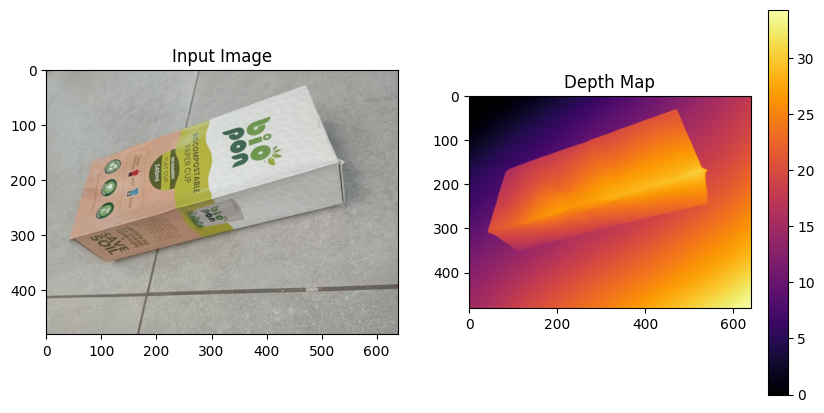

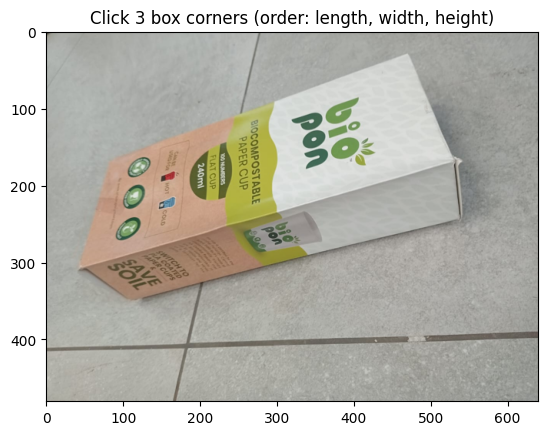

Insufficient points selected


In [ ]:
# ------------------------
# 0. Install Dependencies
# ------------------------
!pip install -q opencv-python-headless torch matplotlib Pillow
!apt-get install -y libgl1-mesa-glx

# ------------------------
# 1. Import Required Libraries
# ------------------------
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import contextlib
from google.colab import files

# Set matplotlib backend for Colab compatibility
%matplotlib inline

# ------------------------
# 2. Image Upload & Handling
# ------------------------
uploaded = files.upload()
image_path = next(iter(uploaded))
img = Image.open(image_path).convert("RGB")

# Resize image to reduce processing load
resize_factor = 2
img = img.resize((img.width//resize_factor, img.height//resize_factor))
img_np = np.array(img)
img_cv = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)

# ------------------------
# 3. Load MiDaS Model (with suppressed output)
# ------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_type = "DPT_Large"

with open(os.devnull, 'w') as f, contextlib.redirect_stdout(f):
    midas = torch.hub.load('intel-isl/MiDaS', model_type).to(device)
    midas.eval()
    midas_transforms = torch.hub.load('intel-isl/MiDaS', 'transforms')
    transform = midas_transforms.dpt_transform

# ------------------------
# 4. Depth Map Estimation
# ------------------------
input_batch = transform(img_np).to(device)

with torch.no_grad():
    prediction = midas(input_batch)
    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img_np.shape[:2],
        mode="bicubic",
        align_corners=False
    ).squeeze()

depth_map = prediction.cpu().numpy()

# ------------------------
# 5. Display Results
# ------------------------
plt.figure(figsize=(10, 5))
plt.subplot(121), plt.imshow(img), plt.title('Input Image')
plt.subplot(122), plt.imshow(depth_map, cmap='inferno'), plt.title('Depth Map')
plt.colorbar()
plt.show()

# ------------------------
# 6. Interactive Dimension Estimation
# ------------------------
clicked_points = []

def onclick(event):
    if event.xdata and event.ydata:
        x, y = int(event.xdata), int(event.ydata)
        clicked_points.append((x, y))
        print(f"Point {len(clicked_points)}: ({x}, {y}), Depth: {depth_map[y,x]:.2f}")
        if len(clicked_points) >= 3: plt.close()

plt.figure()
plt.imshow(img)
plt.title("Click 3 box corners (order: length, width, height)")
plt.connect('button_press_event', onclick)
plt.show()

# ------------------------
# 7. 3D Calculations
# ------------------------
if len(clicked_points) >= 3:
    def calculate_3d_coords(x, y):
        fx = fy = 500  # Focal length assumption
        cx, cy = img.width//2, img.height//2
        Z = depth_map[y, x]
        return [(x - cx) * Z/fx, (y - cy) * Z/fy, Z]

    dimensions = []
    for i in range(3):
        p1 = calculate_3d_coords(*clicked_points[i])
        p2 = calculate_3d_coords(*clicked_points[(i+1)%3])
        dimensions.append(np.linalg.norm(np.array(p1) - np.array(p2)))

    print("\nEstimated Dimensions (relative units):")
    print(f"Length: {dimensions[0]:.2f}")
    print(f"Width: {dimensions[1]:.2f}")
    print(f"Height: {dimensions[2]:.2f}")
else:
    print("Insufficient points selected")


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libgl1-mesa-glx is already the newest version (23.0.4-0ubuntu1~22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 30 not upgraded.


Saving box_image.jpeg to box_image (2).jpeg


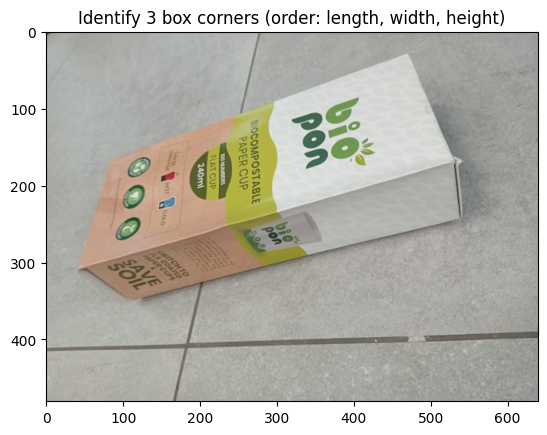

Enter x-coordinate for point 1: 100
Enter y-coordinate for point 1: 160
Point 1: (100, 160)
Enter x-coordinate for point 2: 487
Enter y-coordinate for point 2: 25
Point 2: (487, 25)
Enter x-coordinate for point 3: 190
Enter y-coordinate for point 3: 190
Point 3: (190, 190)


Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


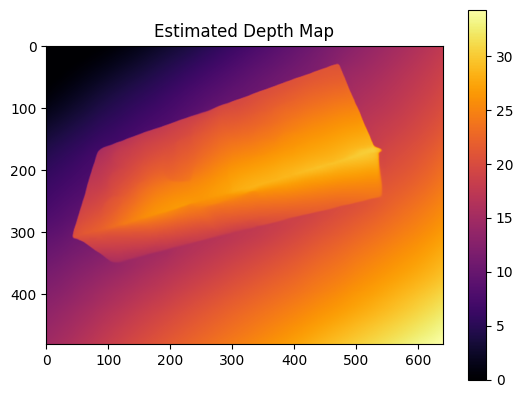

Point (100, 160), Depth: 6.39
Point (487, 25), Depth: 13.52
Point (190, 190), Depth: 21.40

Estimated Dimensions (relative units):
Length: 11.29
Width: 13.31
Height: 15.30


In [ ]:
# Box Dimension Estimation from User-Provided Image using MiDaS

# ------------------------
# 0. Install Dependencies
# ------------------------
!pip install -q opencv-python-headless torch matplotlib Pillow
!apt-get install -y libgl1-mesa-glx

# ------------------------
# 1. Import Required Libraries
# ------------------------
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import contextlib
from google.colab import files

# Set matplotlib backend for Colab compatibility
%matplotlib inline

# ------------------------
# 2. Image Upload & Handling
# ------------------------
uploaded = files.upload()
image_path = next(iter(uploaded))
img = Image.open(image_path).convert("RGB")

# Resize image to reduce processing load
resize_factor = 2
img = img.resize((img.width//resize_factor, img.height//resize_factor))
img_np = np.array(img)
img_cv = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)

# Display the image first
plt.figure()
plt.imshow(img)
plt.title("Identify 3 box corners (order: length, width, height)")
plt.show()

# Manually input coordinates
clicked_points = []
for i in range(3):
    x = int(input(f"Enter x-coordinate for point {i+1}: "))
    y = int(input(f"Enter y-coordinate for point {i+1}: "))
    clicked_points.append((x, y))
    print(f"Point {i+1}: ({x}, {y})")

# ------------------------
# 3. Load MiDaS Model (with suppressed output)
# ------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_type = "DPT_Large"

with open(os.devnull, 'w') as f, contextlib.redirect_stdout(f):
    midas = torch.hub.load('intel-isl/MiDaS', model_type).to(device)
    midas.eval()
    midas_transforms = torch.hub.load('intel-isl/MiDaS', 'transforms')
    transform = midas_transforms.dpt_transform

# ------------------------
# 4. Depth Map Estimation
# ------------------------
input_batch = transform(img_np).to(device)

with torch.no_grad():
    prediction = midas(input_batch)
    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img_np.shape[:2],
        mode="bicubic",
        align_corners=False
    ).squeeze()

depth_map = prediction.cpu().numpy()

# Display depth map
plt.figure()
plt.imshow(depth_map, cmap='inferno')
plt.title("Estimated Depth Map")
plt.colorbar()
plt.show()

# Print depths for clicked points
for x, y in clicked_points:
    print(f"Point ({x}, {y}), Depth: {depth_map[y,x]:.2f}")

# ------------------------
# 7. 3D Calculations
# ------------------------
def calculate_3d_coords(x, y):
    fx = fy = 500  # Focal length assumption
    cx, cy = img.width//2, img.height//2
    Z = depth_map[y, x]
    return [(x - cx) * Z/fx, (y - cy) * Z/fy, Z]

dimensions = []
for i in range(3):
    p1 = calculate_3d_coords(*clicked_points[i])
    p2 = calculate_3d_coords(*clicked_points[(i+1)%3])
    dimensions.append(np.linalg.norm(np.array(p1) - np.array(p2)))

print("\nEstimated Dimensions (relative units):")
print(f"Length: {dimensions[0]:.2f}")
print(f"Width: {dimensions[1]:.2f}")
print(f"Height: {dimensions[2]:.2f}")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 59.9 MB/s eta 0:00:00
box
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libgl1-mesa-glx is already the newest version (23.0.4-0ubuntu1~22.04.1).
0 upgraded, 0 newly installed

Saving box_image.jpeg to box_image.jpeg


/usr/local/lib/python3.11/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/intel-isl/MiDaS/zipball/master" to /root/.cache/torch/hub/master.zip
/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.l

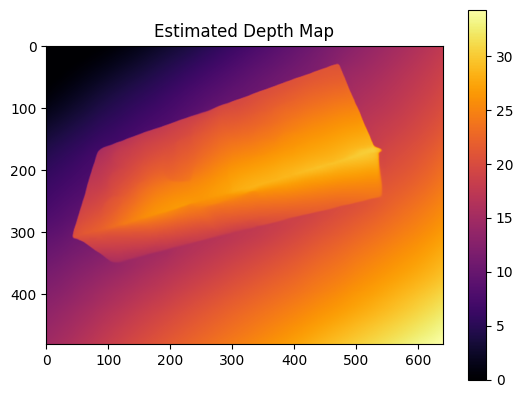

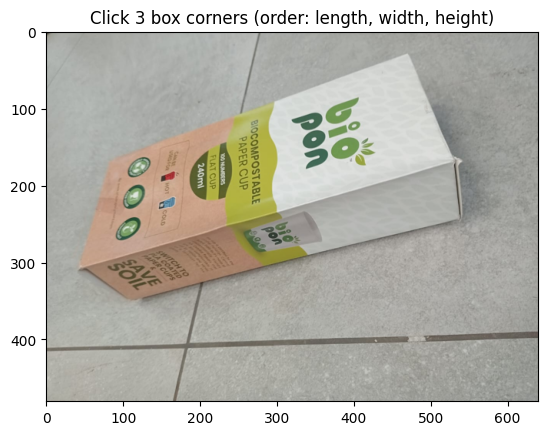

Insufficient points selected.


In [ ]:
# Box Dimension Estimation from User-Provided Image using MiDaS

# ------------------------
# 0. Install Dependencies
# ------------------------
!pip install -q opencv-python-headless torch matplotlib Pillow
!apt-get install -y libgl1-mesa-glx

# ------------------------
# 1. Import Required Libraries
# ------------------------
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import contextlib
from google.colab import files

# Set matplotlib backend for Colab compatibility
%matplotlib inline

# ------------------------
# 2. Image Upload & Handling
# ------------------------
uploaded = files.upload()
image_path = next(iter(uploaded))
img = Image.open(image_path).convert("RGB")

# Resize image to reduce processing load
resize_factor = 2
img = img.resize((img.width//resize_factor, img.height//resize_factor))
img_np = np.array(img)
img_cv = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)

# ------------------------
# 3. Load MiDaS Model (with suppressed output)
# ------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_type = "DPT_Large"

with open(os.devnull, 'w') as f, contextlib.redirect_stdout(f):
    midas = torch.hub.load('intel-isl/MiDaS', model_type).to(device)
    midas.eval()
    midas_transforms = torch.hub.load('intel-isl/MiDaS', 'transforms')
    transform = midas_transforms.dpt_transform

# ------------------------
# 4. Depth Map Estimation
# ------------------------
input_batch = transform(img_np).to(device)

with torch.no_grad():
    prediction = midas(input_batch)
    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img_np.shape[:2],
        mode="bicubic",
        align_corners=False
    ).squeeze()

depth_map = prediction.cpu().numpy()

# Display depth map
plt.figure()
plt.imshow(depth_map, cmap='inferno')
plt.title("Estimated Depth Map")
plt.colorbar()
plt.show()

# ------------------------
# 5. Interactive Dimension Estimation Using Depth Values
# ------------------------
clicked_points = []

def onclick(event):
    if event.xdata and event.ydata:
        x, y = int(event.xdata), int(event.ydata)
        clicked_points.append((x, y))
        print(f"Point {len(clicked_points)}: ({x}, {y}), Depth: {depth_map[y,x]:.2f}")
        if len(clicked_points) >= 3: plt.close()

plt.figure()
plt.imshow(img)
plt.title("Click 3 box corners (order: length, width, height)")
cid = plt.gcf().canvas.mpl_connect('button_press_event', onclick)
plt.show()

# ------------------------
# 6. Calculate Dimensions Using Depth Values
# ------------------------
if len(clicked_points) >= 3:
    def calculate_distance(p1, p2):
        # Extract coordinates and depth values for both points
        x1, y1, x2, y2 = p1[0], p1[1], p2[0], p2[1]
        d1, d2 = depth_map[y1, x1], depth_map[y2, x2]

        # Compute Euclidean distance in 3D space using depth values
        distance = np.sqrt((x2 - x1)**2 + (y2 - y1)**2 + (d2 - d1)**2)
        return distance

    # Calculate distances between the clicked points (Length, Width, Height)
    dimensions = []
    for i in range(3):
        p1 = clicked_points[i]
        p2 = clicked_points[(i+1)%3]
        dist = calculate_distance(p1, p2)
        dimensions.append(dist)

    print("\nEstimated Dimensions (in relative units):")
    print(f"Length: {dimensions[0]:.2f}")
    print(f"Width: {dimensions[1]:.2f}")
    print(f"Height: {dimensions[2]:.2f}")
else:
    print("Insufficient points selected.")


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libgl1-mesa-glx is already the newest version (23.0.4-0ubuntu1~22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 30 not upgraded.


Saving box_image.jpeg to box_image (1).jpeg


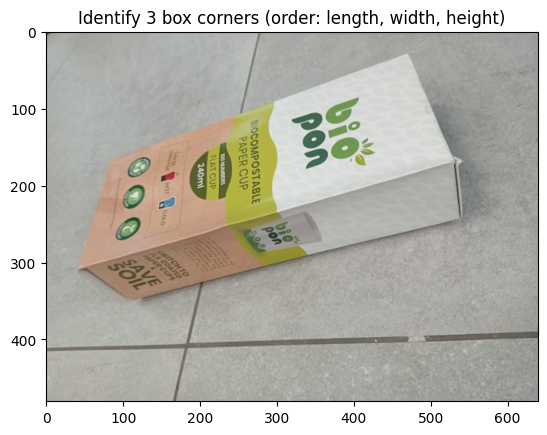

Enter x-coordinate for point 1: 520
Enter y-coordinate for point 1: 180
Point 1: (520, 180)
Enter x-coordinate for point 2: 45
Enter y-coordinate for point 2: 307
Point 2: (45, 307)
Enter x-coordinate for point 3: 480
Enter y-coordinate for point 3: 25
Point 3: (480, 25)


Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


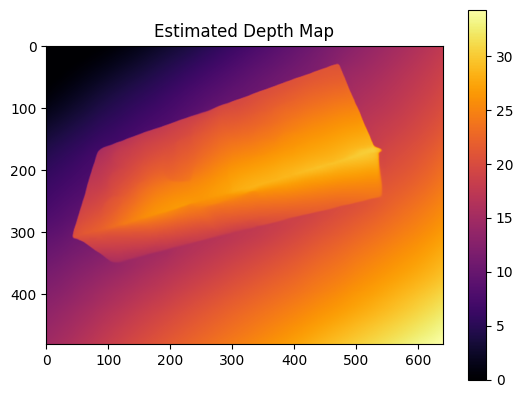

Point (520, 180), Depth: 29.45
Point (45, 307), Depth: 20.65
Point (480, 25), Depth: 13.29

Estimated Dimensions (in relative units):
Length: 491.76
Width: 518.46
Height: 160.89


In [ ]:
# Box Dimension Estimation from User-Provided Image using MiDaS

# ------------------------
# 0. Install Dependencies
# ------------------------
!pip install -q opencv-python-headless torch matplotlib Pillow
!apt-get install -y libgl1-mesa-glx

# ------------------------
# 1. Import Required Libraries
# ------------------------
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import contextlib
from google.colab import files

# Set matplotlib backend for Colab compatibility
%matplotlib inline

# ------------------------
# 2. Image Upload & Handling
# ------------------------
uploaded = files.upload()
image_path = next(iter(uploaded))
img = Image.open(image_path).convert("RGB")

# Resize image to reduce processing load
resize_factor = 2
img = img.resize((img.width//resize_factor, img.height//resize_factor))
img_np = np.array(img)
img_cv = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)

# Display the image first
plt.figure()
plt.imshow(img)
plt.title("Identify 3 box corners (order: length, width, height)")
plt.show()

# Manually input coordinates
clicked_points = []
for i in range(3):
    x = int(input(f"Enter x-coordinate for point {i+1}: "))
    y = int(input(f"Enter y-coordinate for point {i+1}: "))
    clicked_points.append((x, y))
    print(f"Point {i+1}: ({x}, {y})")

# ------------------------
# 3. Load MiDaS Model (with suppressed output)
# ------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_type = "DPT_Large"

with open(os.devnull, 'w') as f, contextlib.redirect_stdout(f):
    midas = torch.hub.load('intel-isl/MiDaS', model_type).to(device)
    midas.eval()
    midas_transforms = torch.hub.load('intel-isl/MiDaS', 'transforms')
    transform = midas_transforms.dpt_transform

# ------------------------
# 4. Depth Map Estimation
# ------------------------
input_batch = transform(img_np).to(device)

with torch.no_grad():
    prediction = midas(input_batch)
    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img_np.shape[:2],
        mode="bicubic",
        align_corners=False
    ).squeeze()

depth_map = prediction.cpu().numpy()

# Display depth map
plt.figure()
plt.imshow(depth_map, cmap='inferno')
plt.title("Estimated Depth Map")
plt.colorbar()
plt.show()

# Print depths for clicked points
for x, y in clicked_points:
    print(f"Point ({x}, {y}), Depth: {depth_map[y,x]:.2f}")

# ------------------------
# 5. Calculate Dimensions Using Depth Values
# ------------------------
def calculate_distance(p1, p2):
    # Extract coordinates and depth values for both points
    x1, y1, x2, y2 = p1[0], p1[1], p2[0], p2[1]
    d1, d2 = depth_map[y1, x1], depth_map[y2, x2]

    # Compute Euclidean distance in 3D space using depth values
    distance = np.sqrt((x2 - x1)**2 + (y2 - y1)**2 + (d2 - d1)**2)
    return distance

# Calculate distances between the clicked points (Length, Width, Height)
dimensions = []
for i in range(3):
    p1 = clicked_points[i]
    p2 = clicked_points[(i+1)%3]
    dist = calculate_distance(p1, p2)
    dimensions.append(dist)

print("\nEstimated Dimensions (in relative units):")
print(f"Length: {dimensions[0]:.2f}")
print(f"Width: {dimensions[1]:.2f}")
print(f"Height: {dimensions[2]:.2f}")


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libgl1-mesa-glx is already the newest version (23.0.4-0ubuntu1~22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 30 not upgraded.


Saving box_image.jpeg to box_image (2).jpeg


Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


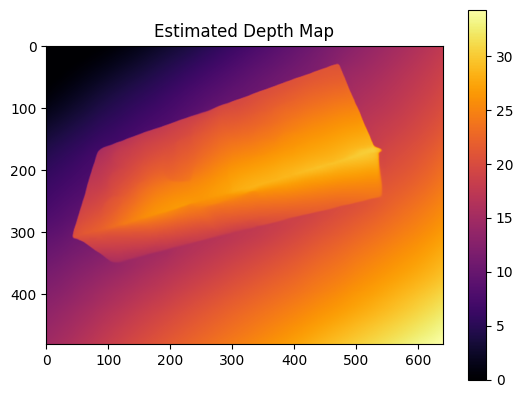

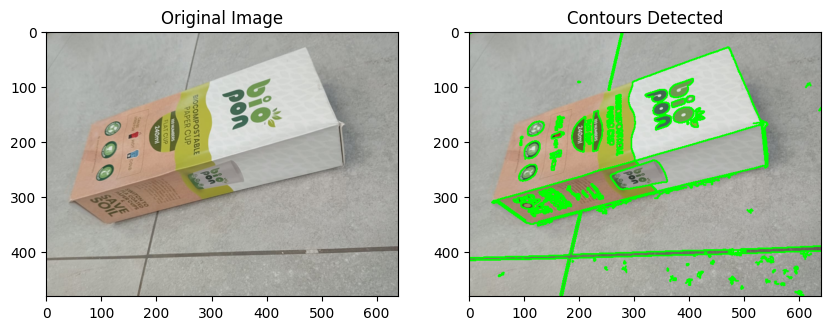


Estimated Dimensions (in relative units):
Object 1: Length: 1.42, Width: 3.00, Height: 1.42
Object 2: Length: 2.00, Width: 1.41, Height: 1.00
Object 3: Length: 1.00, Width: 1.41, Height: 1.42
Object 4: Length: 1.00, Width: 2.83, Height: 1.41
Object 5: Length: 1.00, Width: 1.42, Height: 1.42
Object 6: Length: 4.01, Width: 1.42, Height: 2.00
Object 7: Length: 1.00, Width: 1.42, Height: 1.41
Object 8: Length: 2.00, Width: 5.67, Height: 1.00
Object 9: Length: 1.41, Width: 1.00, Height: 1.41
Object 10: Length: 1.00, Width: 1.41, Height: 1.42
Object 11: Length: 1.41, Width: 1.00, Height: 1.41
Object 12: Length: 2.83, Width: 1.42, Height: 1.41
Object 13: Length: 1.41, Width: 2.00, Height: 2.00
Object 14: Length: 4.24, Width: 1.41, Height: 1.42
Object 15: Length: 1.42, Width: 1.41, Height: 3.00
Object 16: Length: 3.00, Width: 1.00, Height: 1.42
Object 17: Length: 1.42, Width: 3.00, Height: 1.42
Object 18: Length: 1.00, Width: 1.41, Height: 1.00
Object 19: Length: 3.00, Width: 2.00, Height: 1.

In [ ]:
# ------------------------
# 0. Install Dependencies
# ------------------------
!pip install -q opencv-python-headless torch matplotlib Pillow
!apt-get install -y libgl1-mesa-glx

# ------------------------
# 1. Import Required Libraries
# ------------------------
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import contextlib
from google.colab import files

# Set matplotlib backend for Colab compatibility
%matplotlib inline

# ------------------------
# 2. Image Upload & Handling
# ------------------------
uploaded = files.upload()
image_path = next(iter(uploaded))
img = Image.open(image_path).convert("RGB")

# Resize image to reduce processing load
resize_factor = 2
img = img.resize((img.width//resize_factor, img.height//resize_factor))
img_np = np.array(img)
img_cv = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)

# ------------------------
# 3. Load MiDaS Model (Monocular Depth Estimation)
# ------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_type = "DPT_Large"

with open(os.devnull, 'w') as f, contextlib.redirect_stdout(f):
    midas = torch.hub.load('intel-isl/MiDaS', model_type).to(device)
    midas.eval()
    midas_transforms = torch.hub.load('intel-isl/MiDaS', 'transforms')
    transform = midas_transforms.dpt_transform

# ------------------------
# 4. Depth Map Estimation
# ------------------------
input_batch = transform(img_np).to(device)

with torch.no_grad():
    prediction = midas(input_batch)
    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img_np.shape[:2],
        mode="bicubic",
        align_corners=False
    ).squeeze()

depth_map = prediction.cpu().numpy()

# Display depth map
plt.figure()
plt.imshow(depth_map, cmap='inferno')
plt.title("Estimated Depth Map")
plt.colorbar()
plt.show()

# ------------------------
# 5. Edge Detection and Contour Analysis
# ------------------------
gray_img = cv2.cvtColor(img_cv, cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray_img, threshold1=50, threshold2=150)

contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw contours on the original image for visualization
contour_img = img_cv.copy()
cv2.drawContours(contour_img, contours, -1, (0, 255, 0), 2)

plt.figure(figsize=(10, 5))
plt.subplot(121), plt.imshow(img), plt.title('Original Image')
plt.subplot(122), plt.imshow(cv2.cvtColor(contour_img, cv2.COLOR_BGR2RGB)), plt.title('Contours Detected')
plt.show()

# ------------------------
# 6. Dimension Estimation Using Depth Map and Contours
# ------------------------
def calculate_distance(p1, p2):
    # Extract coordinates and depth values for both points
    x1, y1, x2, y2 = p1[0], p1[1], p2[0], p2[1]
    d1, d2 = depth_map[y1, x1], depth_map[y2, x2]

    # Compute Euclidean distance in 3D space using depth values
    distance = np.sqrt((x2 - x1)**2 + (y2 - y1)**2 + (d2 - d1)**2)
    return distance

dimensions = []
for contour in contours:
    if len(contour) >= 4:  # Ensure there are enough points to calculate dimensions
        # Select four points from the contour (corners of the box-like object)
        points = contour[:4].reshape(-1, 2)
        distances = []
        for i in range(len(points)):
            p1 = points[i]
            p2 = points[(i+1) % len(points)]
            dist = calculate_distance(p1, p2)
            distances.append(dist)
        dimensions.append(distances)

print("\nEstimated Dimensions (in relative units):")
for i, dim in enumerate(dimensions):
    print(f"Object {i+1}: Length: {dim[0]:.2f}, Width: {dim[1]:.2f}, Height: {dim[2]:.2f}")


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libgl1-mesa-glx is already the newest version (23.0.4-0ubuntu1~22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 30 not upgraded.


Saving cardboard-box-12876511.webp to cardboard-box-12876511.webp


Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


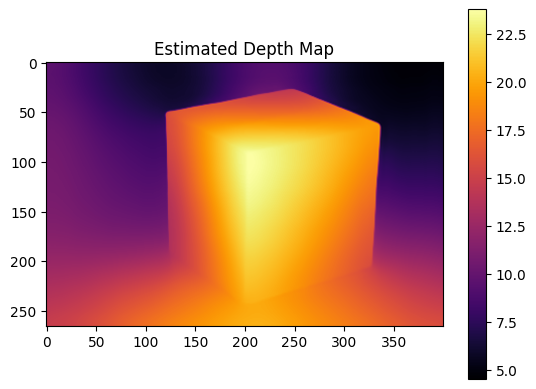

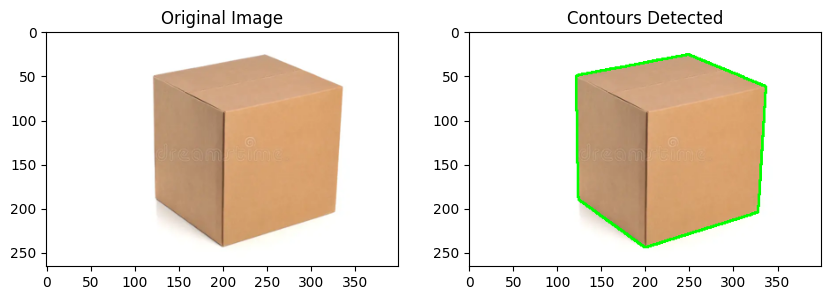


Estimated Dimensions (in relative units):
Object 1: Length: 4.02, Width: 4.52, Height: 2.94


In [ ]:
# ------------------------
# 0. Install Dependencies
# ------------------------
!pip install -q opencv-python-headless torch matplotlib Pillow
!apt-get install -y libgl1-mesa-glx

# ------------------------
# 1. Import Required Libraries
# ------------------------
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import contextlib
from google.colab import files

# Set matplotlib backend for Colab compatibility
%matplotlib inline

# ------------------------
# 2. Image Upload & Handling
# ------------------------
uploaded = files.upload()
image_path = next(iter(uploaded))
img = Image.open(image_path).convert("RGB")

# Resize image to reduce processing load
resize_factor = 2
img = img.resize((img.width//resize_factor, img.height//resize_factor))
img_np = np.array(img)
img_cv = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)

# ------------------------
# 3. Load MiDaS Model (Monocular Depth Estimation)
# ------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_type = "DPT_Large"

with open(os.devnull, 'w') as f, contextlib.redirect_stdout(f):
    midas = torch.hub.load('intel-isl/MiDaS', model_type).to(device)
    midas.eval()
    midas_transforms = torch.hub.load('intel-isl/MiDaS', 'transforms')
    transform = midas_transforms.dpt_transform

# ------------------------
# 4. Depth Map Estimation
# ------------------------
input_batch = transform(img_np).to(device)

with torch.no_grad():
    prediction = midas(input_batch)
    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img_np.shape[:2],
        mode="bicubic",
        align_corners=False
    ).squeeze()

depth_map = prediction.cpu().numpy()

# Display depth map
plt.figure()
plt.imshow(depth_map, cmap='inferno')
plt.title("Estimated Depth Map")
plt.colorbar()
plt.show()

# ------------------------
# 5. Edge Detection and Contour Analysis
# ------------------------
gray_img = cv2.cvtColor(img_cv, cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray_img, threshold1=50, threshold2=150)

contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw contours on the original image for visualization
contour_img = img_cv.copy()
cv2.drawContours(contour_img, contours, -1, (0, 255, 0), 2)

plt.figure(figsize=(10, 5))
plt.subplot(121), plt.imshow(img), plt.title('Original Image')
plt.subplot(122), plt.imshow(cv2.cvtColor(contour_img, cv2.COLOR_BGR2RGB)), plt.title('Contours Detected')
plt.show()

# ------------------------
# 6. Dimension Estimation Using Depth Map and Contours
# ------------------------
def calculate_distance(p1, p2):
    # Extract coordinates and depth values for both points
    x1, y1, x2, y2 = p1[0], p1[1], p2[0], p2[1]
    d1, d2 = depth_map[y1, x1], depth_map[y2, x2]

    # Compute Euclidean distance in 3D space using depth values
    distance = np.sqrt((x2 - x1)**2 + (y2 - y1)**2 + (d2 - d1)**2)
    return distance

dimensions = []
for contour in contours:
    if len(contour) >= 4:  # Ensure there are enough points to calculate dimensions
        # Select four points from the contour (corners of the box-like object)
        points = contour[:4].reshape(-1, 2)
        distances = []
        for i in range(len(points)):
            p1 = points[i]
            p2 = points[(i+1) % len(points)]
            dist = calculate_distance(p1, p2)
            distances.append(dist)
        dimensions.append(distances)

print("\nEstimated Dimensions (in relative units):")
for i, dim in enumerate(dimensions):
    print(f"Object {i+1}: Length: {dim[0]:.2f}, Width: {dim[1]:.2f}, Height: {dim[2]:.2f}")


In [ ]:
# ------------------------
# 0. Install Dependencies
# ------------------------
!pip install -q opencv-python-headless torch matplotlib Pillow
!apt-get install -y libgl1-mesa-glx

# ------------------------
# 1. Import Required Libraries
# ------------------------
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import contextlib
from google.colab import files

# Set matplotlib backend for Colab compatibility
%matplotlib inline

# ------------------------
# 2. Image Upload & Handling
# ------------------------
uploaded = files.upload()
image_path = next(iter(uploaded))
img = Image.open(image_path).convert("RGB")

# Resize image to reduce processing load
resize_factor = 2
img = img.resize((img.width//resize_factor, img.height//resize_factor))
img_np = np.array(img)
img_cv = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)

# ------------------------
# 3. Load MiDaS Model (Monocular Depth Estimation)
# ------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_type = "DPT_Large"

with open(os.devnull, 'w') as f, contextlib.redirect_stdout(f):
    midas = torch.hub.load('intel-isl/MiDaS', model_type).to(device)
    midas.eval()
    midas_transforms = torch.hub.load('intel-isl/MiDaS', 'transforms')
    transform = midas_transforms.dpt_transform

# ------------------------
# 4. Depth Map Estimation
# ------------------------
input_batch = transform(img_np).to(device)

with torch.no_grad():
    prediction = midas(input_batch)
    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img_np.shape[:2],
        mode="bicubic",
        align_corners=False
    ).squeeze()

depth_map = prediction.cpu().numpy()

# Display depth map
plt.figure()
plt.imshow(depth_map, cmap='inferno')
plt.title("Estimated Depth Map")
plt.colorbar()
plt.show()

# ------------------------
# 5. Edge Detection and Contour Analysis
# ------------------------
gray_img = cv2.cvtColor(img_cv, cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray_img, threshold1=50, threshold2=150)

contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw contours on the original image for visualization
contour_img = img_cv.copy()
cv2.drawContours(contour_img, contours, -1, (0, 255, 0), 2)

plt.figure(figsize=(10, 5))
plt.subplot(121), plt.imshow(img), plt.title('Original Image')
plt.subplot(122), plt.imshow(cv2.cvtColor(contour_img, cv2.COLOR_BGR2RGB)), plt.title('Contours Detected')
plt.show()

# ------------------------
# 6. Dimension Estimation Using Depth Map and Contours
# ------------------------
def calculate_distance(p1, p2):
    # Extract coordinates and depth values for both points
    x1, y1, x2, y2 = p1[0], p1[1], p2[0], p2[1]
    d1, d2 = depth_map[y1, x1], depth_map[y2, x2]

    # Compute Euclidean distance in 3D space using depth values
    distance = np.sqrt((x2 - x1)**2 + (y2 - y1)**2 + (d2 - d1)**2)
    return distance

dimensions = []
for contour in contours:
    if len(contour) >= 4:  # Ensure there are enough points to calculate dimensions
        # Select four points from the contour (corners of the box-like object)
        points = contour[:4].reshape(-1, 2)
        distances = []
        for i in range(len(points)):
            p1 = points[i]
            p2 = points[(i+1) % len(points)]
            dist = calculate_distance(p1, p2)
            distances.append(dist)
        dimensions.append(distances)

print("\nEstimated Dimensions (in relative units):")
for i, dim in enumerate(dimensions):
    print(f"Object {i+1}: Length: {dim[0]:.2f}, Width: {dim[1]:.2f}, Height: {dim[2]:.2f}")
